In [5]:
import mira
import anndata
import torch
from torch import nn
import numpy as np
from torch.distributions import MultivariateNormal
from mira.topic_model.mine import Mine, get_statistics_network, ConcatLayer
from mira.topic_model.base import encoder_layer
import seaborn as sns
from tqdm.notebook import tqdm

class MultivariateNormalDataset(torch.utils.data.Dataset):
    def __init__(self, N, dim, rho):
        self.N = N
        self.rho = rho
        self.dim = dim

        self.dist = self.build_dist
        self.x = self.dist.sample((N, ))
        self.dim = dim

    def __getitem__(self, ix):
        a, b = self.x[ix, 0:self.dim], self.x[ix, self.dim:2 * self.dim]
        return a, b

    def __len__(self):
        return self.N

    @property
    def build_dist(self):
        mu = torch.zeros(2 * self.dim)
        dist = MultivariateNormal(mu, self.cov_matrix)
        return dist

    @property
    def cov_matrix(self):
        cov = torch.zeros((2 * self.dim, 2 * self.dim))
        cov[torch.arange(self.dim), torch.arange(
            start=self.dim, end=2 * self.dim)] = self.rho
        cov[torch.arange(start=self.dim, end=2 * self.dim),
            torch.arange(self.dim)] = self.rho
        cov[torch.arange(2 * self.dim), torch.arange(2 * self.dim)] = 1.0

        return cov

    @property
    def true_mi(self):
        return -0.5 * np.log(np.linalg.det(self.cov_matrix.data.numpy()))

In [136]:
N = 3000
rho = 0.9
batch_size = 512
dim = 1

hidden = 100

T = nn.Sequential(
        ConcatLayer(1),
        nn.Linear(2*dim,hidden), nn.ReLU(), nn.Dropout(0.1),
        nn.Linear(hidden, hidden), nn.ReLU(), nn.Dropout(0.1),
        nn.Linear(hidden, 1),
    )
model = Mine(T, alpha=0.01)

In [137]:
data = MultivariateNormalDataset(N, 1, rho)
print(data.true_mi)

def batch(x, y, batch_size=1, shuffle=True):
    assert len(x) == len(
        y), "Input and target data must contain same number of elements"
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x).float()
    if isinstance(y, np.ndarray):
        y = torch.from_numpy(y).float()

    n = len(x)

    if shuffle:
        rand_perm = torch.randperm(n)
        x = x[rand_perm]
        y = y[rand_perm]

    batches = []
    for i in range(n // batch_size):
        x_b = x[i * batch_size: (i + 1) * batch_size]
        y_b = y[i * batch_size: (i + 1) * batch_size]

        batches.append((x_b, y_b))
    return batches


def optimize(self, X, Y, iters, batch_size, opt=None):

    opt = torch.optim.Adam(
                model.parameters(),  lr = 1e-4, betas = (0.95, 0.999),
                eps=1e-3
            )
    
    losses = []
    for i in tqdm(range(1, iters + 1)):
        mu_mi = 0
        j = 0
        for x, y in batch(X, Y, batch_size):
            opt.zero_grad()
            loss = self.forward(x, y)
            loss.backward()
            opt.step()

            mu_mi -= loss.item()
            
            j += 1
        losses.append(mu_mi/ j)
        
    return losses

0.8303655385971069


In [138]:
losses = optimize(model, data.x[:,0].reshape((-1,1)), data.x[:,1].reshape((-1,1)), 200, 64)

  0%|          | 0/200 [00:00<?, ?it/s]

In [139]:
min(losses)

0.03418870691372001

<AxesSubplot:>

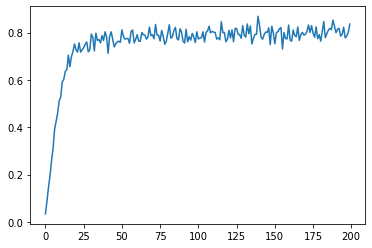

In [140]:
sns.lineplot(
    y = losses,
    x = range(len(losses))
)

In [118]:
data = MultivariateNormalDataset(1000, 1, rho)

In [119]:
model.training = False

In [120]:
model.mi(data.x[:,0].reshape((-1,1)), data.x[:,1].reshape((-1,1)))

tensor(0.7505)

In [55]:
data.true_mi

0.8303655385971069

In [1]:
import anndata
import mira
import scanpy as sc
import seaborn as sns
import numpy as np

class CovarModel(mira.topics.ExpressionTopicModel, mira.topics.CovariateModel):
    pass

adata = anndata.read_h5ad('../../frankencell/data/read_depth_tests/datasets/rd_test_trial_70_data.h5ad')

rna_frankendata = adata[:, adata.var.feature_type == 'RNA']
sc.pp.filter_genes(rna_frankendata, min_cells = 30)

rna_frankendata.raw = rna_frankendata
sc.pp.normalize_total(rna_frankendata, target_sum=1e4)
sc.pp.log1p(rna_frankendata)

sc.pp.highly_variable_genes(rna_frankendata)
sc.tl.pca(rna_frankendata)

rna_frankendata.layers['counts'] = rna_frankendata.raw.to_adata().X

rna_model = CovarModel(
    endogenous_key= 'highly_variable',
    exogenous_key='highly_variable',
    beta = 0.9,
    seed = 2556,
    num_topics = 3,
    min_learning_rate=1e-2,
    max_learning_rate=0.11,
    batch_size=32,
    num_epochs=40,
    encoder_dropout=0.015,
    counts_layer = 'counts',
    kl_strategy='cyclic',
    covariates_key = ['mix_weight_2']
)

#rna_model.get_learning_rate_bounds(rna_frankendata, num_epochs=10)
rna_model.set_learning_rates(0.0013881938462609533, 0.16588926221320652)

rna_model.fit(rna_frankendata)
rna_model.predict(rna_frankendata)
rna_model.get_hierarchical_umap_features(rna_frankendata, box_cox=0.8)

Trying to set attribute `.var` of view, copying.
INFO:mira.adata_interface.topic_model:Predicting expression from genes from col: highly_variable
INFO:mira.adata_interface.topic_model:Using highly-variable genes from col: highly_variable


Epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

INFO:mira.topic_model.base:Moving model to device: cpu


Predicting latent vars:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Added key to uns: topic_dendogram
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.topic_model:Fetching key topic_dendogram from uns
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features


<AxesSubplot:>

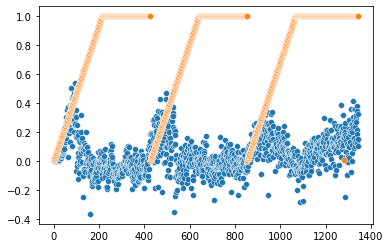

In [2]:
sns.scatterplot(
    y = rna_model.mine_losses,
    x = range(len(rna_model.mine_losses))
)

sns.scatterplot(
    y = rna_model.anneal_factors,
    x = range(len(rna_model.anneal_factors))
)

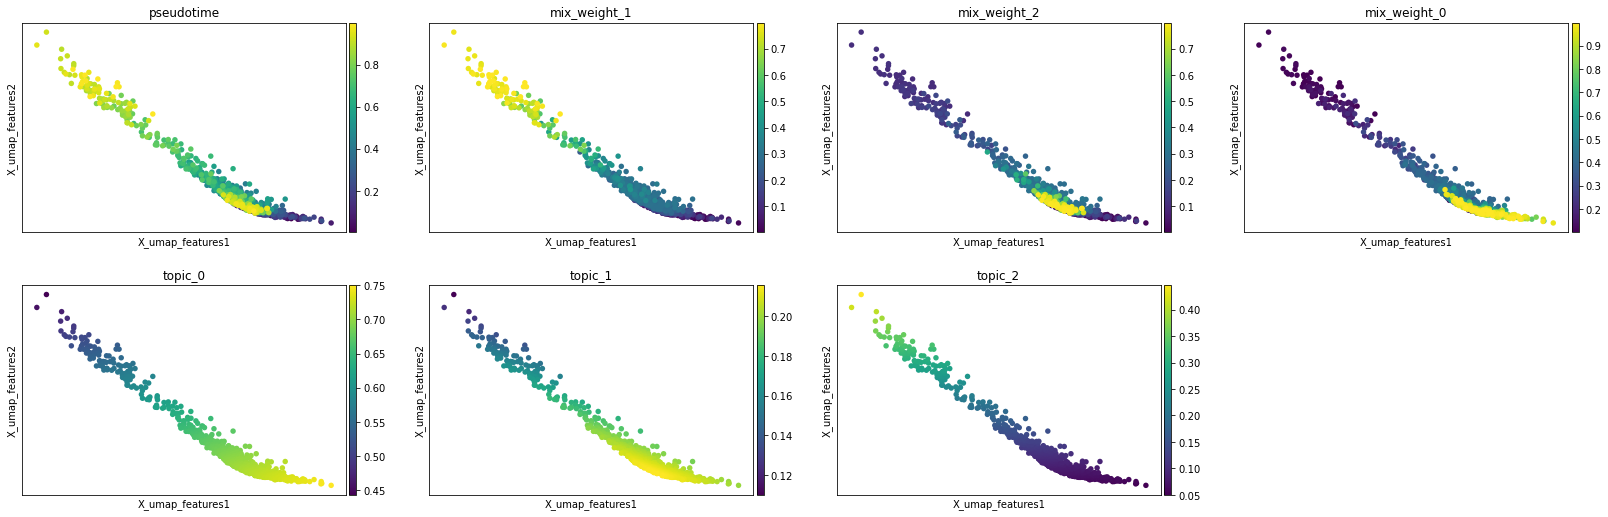

In [3]:
sc.pl.embedding(rna_frankendata, basis = 'X_umap_features', components=('1,2'),
               color = ['pseudotime','mix_weight_1','mix_weight_2','mix_weight_0'] + list(rna_model.topic_cols))

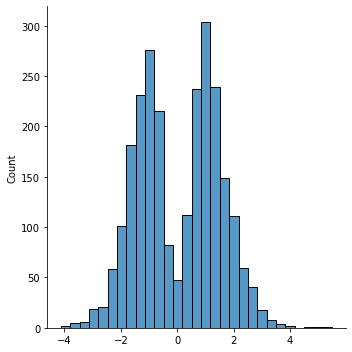

In [4]:
sns.displot(rna_model.decoder.batch_effect_gamma.detach())

In [5]:
rna_model.impute(rna_frankendata)
rna_model.get_batch_effect(rna_frankendata)

INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.topic_model.base:Predicting latent variables ...


Imputing features:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added layer: imputed
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.topic_model.base:Predicting latent variables ...


Imputing features:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added layer: batch_effect


SDHAF1 ATRIP LRRC7 DOCK9 FANCC EPHA1-AS1 SCAI CD96 AC015853.3 CCR7 ARMC6 SCML4 CHKB-DT DNAJC17 HTATIP2 GPRIN3

[None]

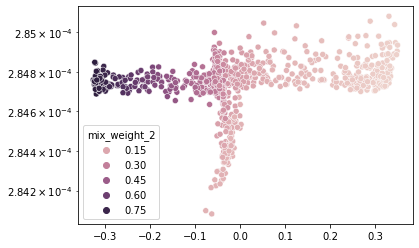

In [6]:
sns.scatterplot(
    y = rna_frankendata.obs_vector('MFSD11', layer='imputed'),
    x = rna_frankendata.obs_vector('MFSD11', layer='batch_effect'),
    hue = rna_frankendata.obs['mix_weight_2'],
).set(yscale = 'log')

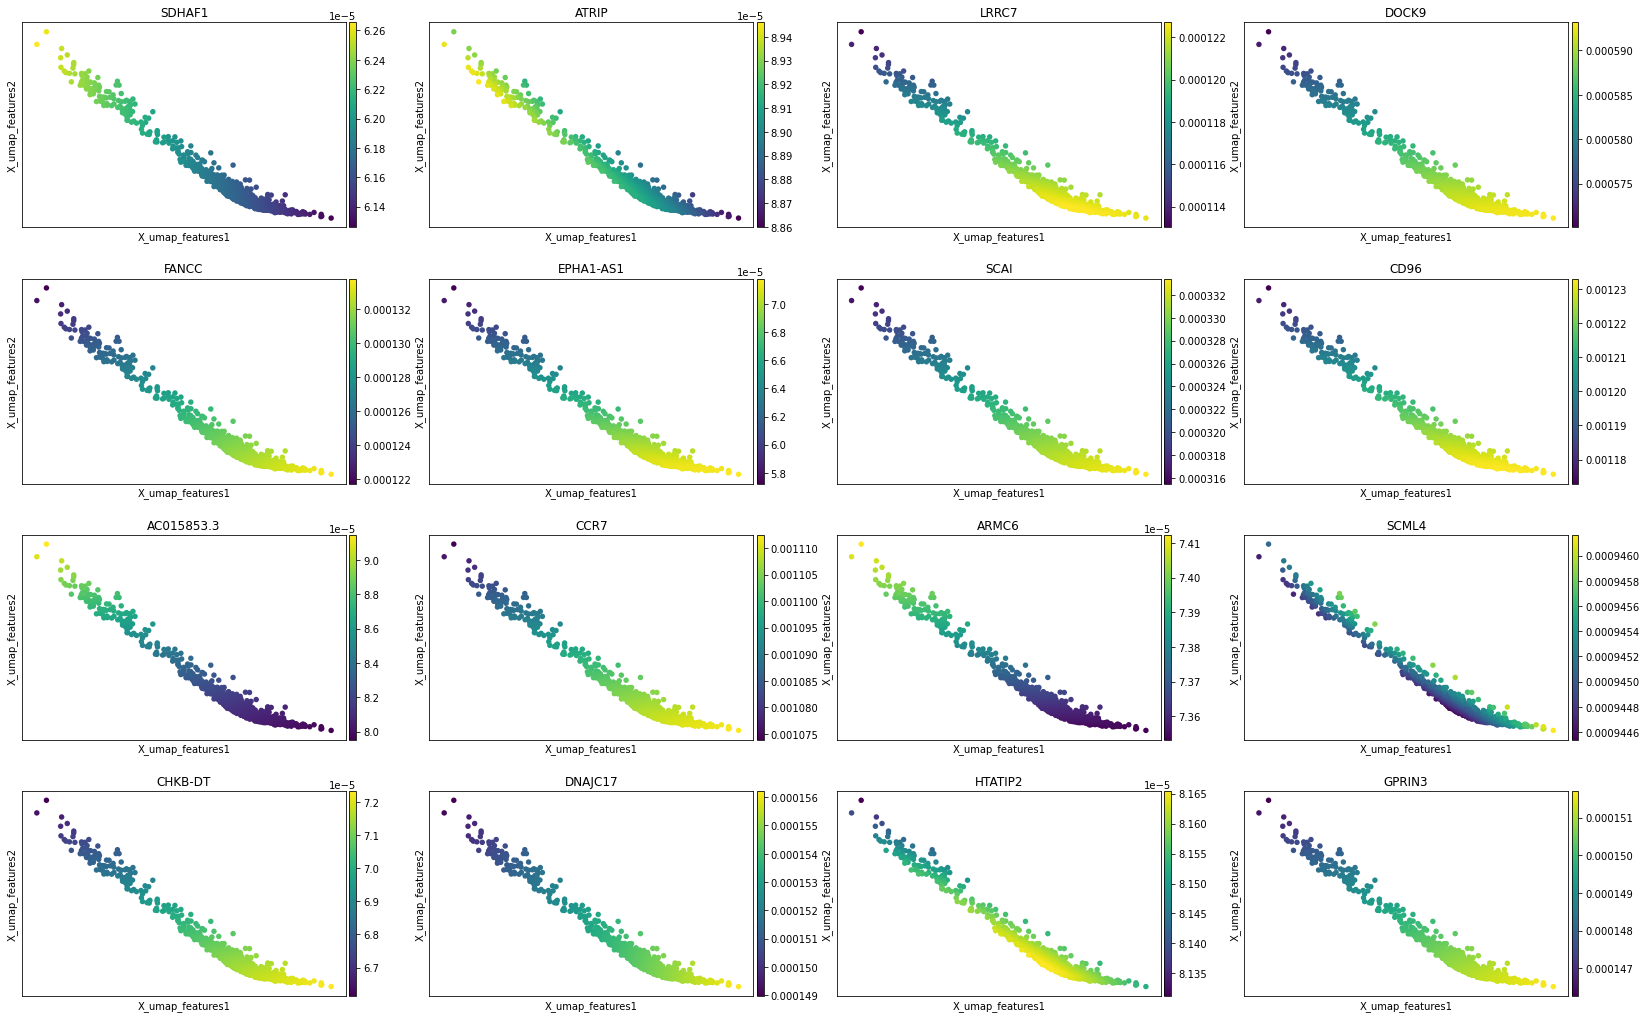

In [7]:
sc.pl.embedding(rna_frankendata, color = ['SDHAF1', 'ATRIP', 'LRRC7', 'DOCK9', 'FANCC', 'EPHA1-AS1', 'SCAI',
       'CD96', 'AC015853.3', 'CCR7', 'ARMC6', 'SCML4', 'CHKB-DT',
       'DNAJC17', 'HTATIP2', 'GPRIN3'], basis = 'X_umap_features', layer='imputed')

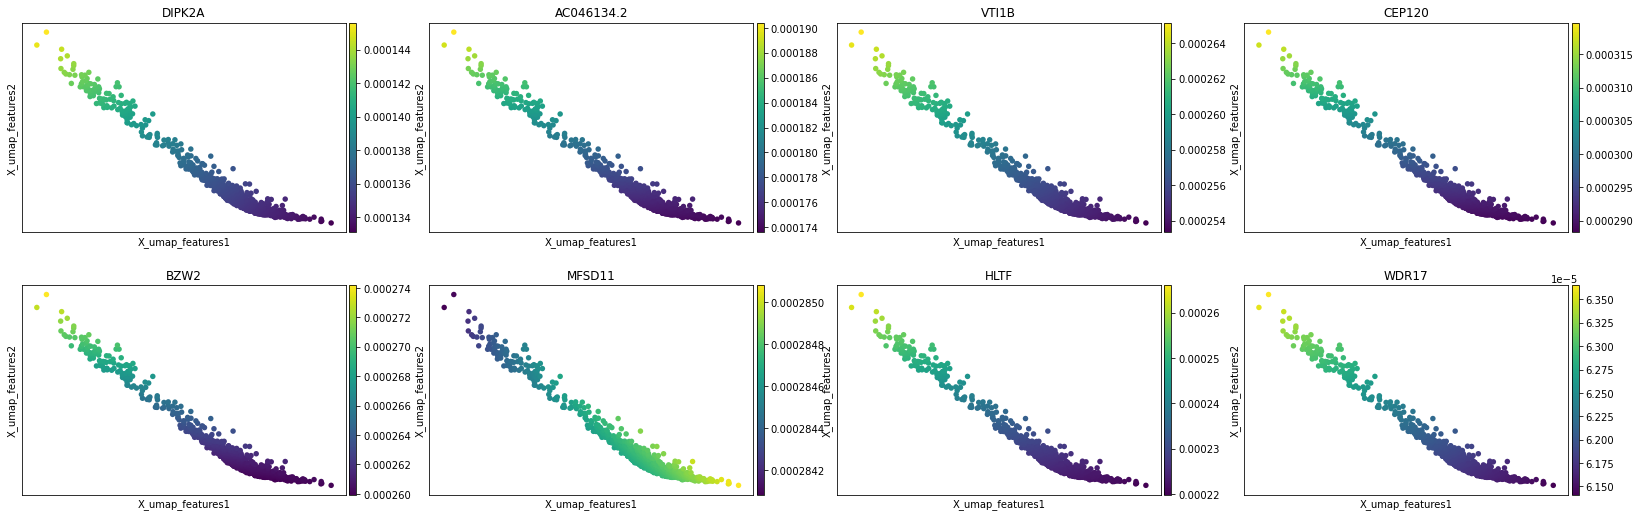

In [8]:
sc.pl.embedding(rna_frankendata, color = rna_model.get_top_genes(2,8), basis = 'X_umap_features', layer='imputed')